<a href="https://colab.research.google.com/github/dadabeckmann/Masterarbeit_Code/blob/main/GEE_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
import ee
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize(project='ee-dbeckmann')

In [68]:
# Packages
import ee
import matplotlib.pyplot as plt # for plots
import branca.colormap as cm # for colormaps
import folium
import geemap
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime


In [69]:
# Load in Shapefile
regionInt = ee.FeatureCollection('users/dbeckmann/Tuebingen_Shape')

# Define constants
START_DATE = '2018-01-01'
END_DATE = '2018-12-31'
MAX_CLOUD_COVER = 50

# Function to filter out cloudy pixels
def cloud_mask(img):
    cloud_shadow_bit_mask = (1 << 3)  # Bits 3 and 5 are cloud shadow and cloud, respectively.
    clouds_bit_mask = (1 << 5)
    qa = img.select('QA_PIXEL')  # Get the pixel QA band.
    mask = qa.bitwiseAnd(cloud_shadow_bit_mask).eq(0) \
                 .And(qa.bitwiseAnd(clouds_bit_mask).eq(0))  # Both flags should be set to zero, indicating clear conditions.
    return img.updateMask(mask)

# Load the collection, apply cloud mask, and filter to date and region of interest.
col_before = ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA') \
    .filterDate(START_DATE, END_DATE)

col_count_before = col_before.size().getInfo()
print('Col before Cloud Filter:', col_count_before)

col_after = ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA') \
    .filterBounds(regionInt) \
    .filterDate(START_DATE, END_DATE) \
    .map(cloud_mask) \
    .filter(ee.Filter.lt('CLOUD_COVER', MAX_CLOUD_COVER))




Col before Cloud Filter: 164698


In [70]:
# Count used images
image_count = col_after.size().getInfo()
print('Number of images in Sentinel-2 collection:', image_count)

# Show dates of used images
dates = col_after.aggregate_array('system:time_start')
formatted_dates = ee.List(dates).map(lambda date: ee.Date(date).format('YYYY-MM-dd')).sort().getInfo()

# Print the sorted dates
print('Used Dates:', formatted_dates)


Number of images in Sentinel-2 collection: 11
Used Dates: ['2018-03-08', '2018-03-24', '2018-04-25', '2018-05-18', '2018-06-03', '2018-07-14', '2018-07-30', '2018-08-06', '2018-08-22', '2018-09-16', '2018-10-18']


Median LST from Region of Interest

In [ ]:
######## LST Berechnung #########
# Generate median composite
image = col_after.median()

# Select thermal band 10 (with brightness temperature)
thermal = image.select('B10') \
    .clip(regionInt) \

# Calculate Normalized Difference Vegetation Index (NDVI) from Landsat surface reflectance
ndvi = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filterBounds(regionInt) \
    .filterDate('2018-01-01', '2018-12-31') \
    .median() \
    .normalizedDifference(['SR_B5', 'SR_B4']) \
    .rename('NDVI') \
    .clip(regionInt) \

# Find the minimum and maximum of NDVI
min_max = ndvi.reduceRegion(
    reducer=ee.Reducer.minMax(),
    geometry=regionInt,
    scale=30,
    maxPixels=1e9
)

# Calculate fractional vegetation
min_val = ee.Number(min_max.get('NDVI_min'))
max_val = ee.Number(min_max.get('NDVI_max'))
fv = ndvi.subtract(min_val).divide(max_val.subtract(min_val)).rename('FV')

# Emissivity calculations
a = ee.Number(0.004)
b = ee.Number(0.986)
em = fv.multiply(a).add(b).rename('EMM')

# Calculate LST from emissivity and brightness temperature
lst_landsat_median = thermal.expression(
    '(Tb / (1 + (0.001145 * (Tb / 1.438)) * log(Ep))) - 273.15',
    {
        'Tb': thermal.select('B10'),
        'Ep': em.select('EMM')
    })

# Function to load in the vizparams

def add_ee_layer(map, ee_image, vis_params, region, name):
    """Add Earth Engine tile layer to Folium map."""
    # Get the URL of the Earth Engine TileLayer with a specified region and visualization parameters
    tile_url = ee_image.getMapId(vis_params)['tile_fetcher'].url_format

    # Add Earth Engine tile layer to Folium map
    folium.TileLayer(
        tiles=tile_url,
        attr=name,
        name=name,
        overlay=True,
    ).add_to(map)

    return map

# Create a map centered around the region of interest
map = folium.Map(location=[48.521637, 9.057645], zoom_start=10)

# Define visualization parameters
thermal_vis = {'min': 295, 'max': 310, 'palette': ['#2b83ba', '#abdda4', '#ffffbf', '#fdae61', '#d7191c', '#abdda4']}
ndvi_vis = {'min': 0, 'max': 1, 'palette': ['blue', 'white', 'green']}
fv_vis = {'min': 0, 'max': 1, 'palette': ['blue', 'white', 'green']}
em_vis = {'min': 0, 'max': 0.99, 'palette': ['blue', 'white', 'green']}
lst_vis = {'min': 15, 'max': 35, 'palette': ['#2b83ba', '#abdda4', '#ffffbf', '#fdae61', '#d7191c', '#abdda4']}

# Add layers to the map using the function
map = add_ee_layer(map, thermal, thermal_vis, regionInt, 'Landsat_BT')
map = add_ee_layer(map, ndvi, ndvi_vis, regionInt, 'NDVI')
map = add_ee_layer(map, ndvi, fv_vis, regionInt, 'Fractional Vegetation')
map = add_ee_layer(map, ndvi, em_vis, regionInt, 'Emissivity')
map = add_ee_layer(map, lst_landsat_median, lst_vis, regionInt, 'LST_Landsat_Median')

# Add layer control to toggle different layers
folium.LayerControl().add_to(map)

# Create a color map for the temperature range
temperature_colormap = cm.LinearColormap(lst_vis['palette'],
                                         vmin=lst_vis['min'],
                                         vmax=lst_vis['max'])
legend_html = '''
    <div style="position: fixed; bottom: 50px; left: 50px; z-index:1000; background-color: white; border: 2px solid grey; padding: 10px;">
        <p><strong>Legend:</strong></p>
        <p><span style="background-color: #2b83ba; padding: 2px 5px;"></span> 15°C - 20°C</p>
        <p><span style="background-color: #abdda4; padding: 2px 5px;"></span> 20°C - 25°C</p>
        <p><span style="background-color: #ffffbf; padding: 2px 5px;"></span> 25°C - 30°C</p>
        <p><span style="background-color: #fdae61; padding: 2px 5px;"></span> 30°C - 35°C</p>
        <p><span style="background-color: #d7191c; padding: 2px 5px;"></span> > 35°C</p>
    </div>
'''

# Add the color map to the map legend
temperature_colormap.caption = 'Temperature (°C)'
map.add_child(temperature_colormap)

# map.get_root().html.add_child(folium.Element(legend_html))

# Display the map
map

Structure Types

In [ ]:
# Structure Type LST Maps
image = ee.Image("JRC/GHSL/P2023A/GHS_BUILT_C/2018")
GHSL = image.select('built_characteristics')

# Define masks for different structure types
maskOpenSpace = GHSL.eq(1).Or(GHSL.eq(2)).Or(GHSL.eq(3)).Or(GHSL.eq(4))
maskBuiltSpacesRes = GHSL.eq(11).Or(GHSL.eq(12)).Or(GHSL.eq(13)).Or(GHSL.eq(14)).Or(GHSL.eq(15))
maskBuiltSpacesNonRes = GHSL.eq(5).Or(GHSL.eq(21)).Or(GHSL.eq(22)).Or(GHSL.eq(23)).Or(GHSL.eq(24)).Or(GHSL.eq(25))
maskUrban = maskBuiltSpacesRes.Or(maskBuiltSpacesNonRes)

# Apply masks to NDVI, emissivity, and LST calculations
ndvi_open_space = ndvi.updateMask(maskOpenSpace)
em_open_space = em.updateMask(maskOpenSpace)
lst_open_space = lst_landsat_median.updateMask(maskOpenSpace)

ndvi_built_res = ndvi.updateMask(maskBuiltSpacesRes)
em_built_res = em.updateMask(maskBuiltSpacesRes)
lst_built_res = lst_landsat_median.updateMask(maskBuiltSpacesRes)

ndvi_built_non_res = ndvi.updateMask(maskBuiltSpacesNonRes)
em_built_non_res = em.updateMask(maskBuiltSpacesNonRes)
lst_built_non_res = lst_landsat_median.updateMask(maskBuiltSpacesNonRes)

ndvi_urban = ndvi.updateMask(maskUrban)
em_urban = em.updateMask(maskUrban)
lst_urban = lst_landsat_median.updateMask(maskUrban)

# Visualize the results
map = folium.Map(location=[48.521637, 9.057645], zoom_start=12)

map = add_ee_layer(map, lst_open_space, lst_vis, regionInt, 'LST_Open_Space')
map = add_ee_layer(map, lst_built_res, lst_vis, regionInt, 'LST_Built_Res')
map = add_ee_layer(map, lst_built_non_res, lst_vis, regionInt, 'LST_Built_Non_Res')
map = add_ee_layer(map, lst_urban, lst_vis, regionInt, 'LST_Urban')

# Add layer control
folium.LayerControl().add_to(map)

# Display the map
map


Median LST per Structure Type



In [ ]:
# Calculate median temperature for each structure type
median_lst_open_space = lst_open_space.reduceRegion(reducer=ee.Reducer.median(), geometry=regionInt, scale=30, maxPixels=1e9).get('B10')
median_lst_built_res = lst_built_res.reduceRegion(reducer=ee.Reducer.median(), geometry=regionInt, scale=30, maxPixels=1e9).get('B10')
median_lst_built_non_res = lst_built_non_res.reduceRegion(reducer=ee.Reducer.median(), geometry=regionInt, scale=30, maxPixels=1e9).get('B10')
median_lst_urban = lst_urban.reduceRegion(reducer=ee.Reducer.median(), geometry=regionInt, scale=30, maxPixels=1e9).get('B10')

# Convert median temperatures from Earth Engine objects to Python variables
median_lst_open_space = median_lst_open_space.getInfo()
median_lst_built_res = median_lst_built_res.getInfo()
median_lst_built_non_res = median_lst_built_non_res.getInfo()
median_lst_urban = median_lst_urban.getInfo()

# Define structure types and their median temperatures
structure_types = ['Open Space', 'Built Residential', 'Built Non-Residential', 'Urban']
median_temperatures = [median_lst_open_space, median_lst_built_res, median_lst_built_non_res, median_lst_urban]

# Create a bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(structure_types, median_temperatures, color='skyblue', width=0.5)

# Add data labels to the bars
for bar, temp in zip(bars, median_temperatures):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, f'{temp:.2f}°C', ha='center', va='bottom')

# Add labels and title
plt.xlabel('Structure Type')
plt.ylabel('Median Temperature (°C)')
plt.title('Median Temperature for Different Structure Types')

# Customize the plot
plt.ylim(0, 40)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()


# Show plot
plt.show()


Area by Structure Type

In [ ]:
def calculate_area(image):
    # Multiply the image by pixel area to get the area in square meters
    area_image = image.multiply(ee.Image.pixelArea())

    # Reduce the area image within the specified region
    area_stats = area_image.reduceRegion(reducer=ee.Reducer.sum(), geometry=regionInt.geometry(), scale=10)

    # Get the sum of the area
    area_sqm = area_stats.get('built_characteristics')

    # Convert to square kilometers
    area_sqkm = ee.Number(area_sqm).divide(1e6).getInfo()

    return area_sqkm

# Calculate areas for each structure type
urban_area_sqkm = calculate_area(maskUrban)
openSpaces_area_sqkm = calculate_area(maskOpenSpace)
builtSpacesRes_area_sqkm = calculate_area(maskBuiltSpacesRes)
builtSpacesNonRes_area_sqkm = calculate_area(maskBuiltSpacesNonRes)

# Print the results
print('Urban Structures (km²):', urban_area_sqkm)
print('Open Spaces (km²):', openSpaces_area_sqkm)
print('Built Spaces Residential (km²):', builtSpacesRes_area_sqkm)
print('Built Spaces Non-Residential (km²):', builtSpacesNonRes_area_sqkm)


# Define structure types and their areas
structure_types = ['Urban Structures', 'Open Spaces', 'Built Spaces Residential', 'Built Spaces Non-Residential']
areas_sqkm = [urban_area_sqkm, openSpaces_area_sqkm, builtSpacesRes_area_sqkm, builtSpacesNonRes_area_sqkm]

# Sort structure types and areas_sqkm based on areas_sqkm
structure_types_sorted, areas_sqkm_sorted = zip(*sorted(zip(structure_types, areas_sqkm), key=lambda x: x[1], reverse=True))

# Create a bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(structure_types_sorted, areas_sqkm_sorted, color='skyblue')

# Add data labels to the bars
for bar, area in zip(bars, areas_sqkm_sorted):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, f'{area:.2f} km²', ha='center', va='bottom')

# Add labels and title
plt.xlabel('Structure Type')
plt.ylabel('Area (km²)')
plt.title('Area of Different Structure Types')

# Customize the plot
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show plot
plt.show()


# Zeitreihe Städte

           Date     LST
0  Jan 26, 2000  -7.959
3  Feb 27, 2000   8.510
5  Mar 21, 2000   7.989
6   Apr 6, 2000  11.592
7  Apr 22, 2000  28.079


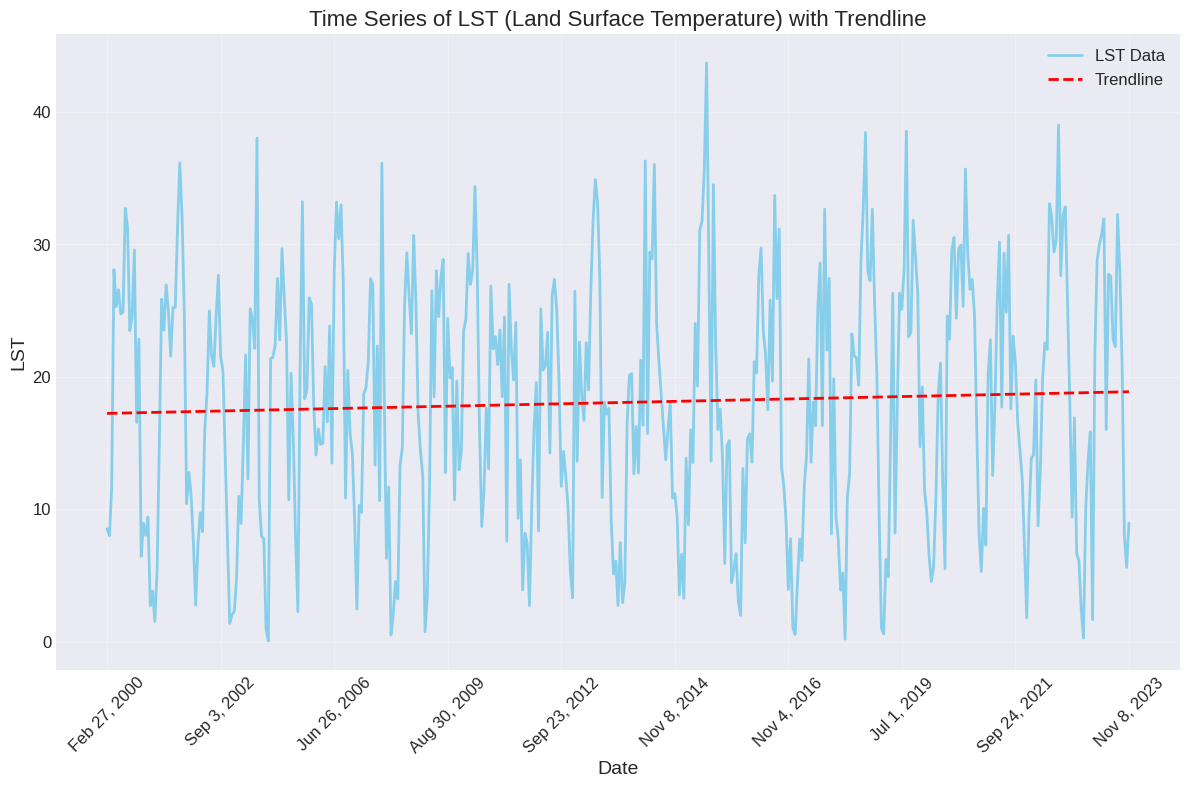

In [113]:
# Import pandas
import pandas as pd
import os
import numpy as np
from google.colab import drive

# Change directory to where your CSV file is located
os.chdir("/content/drive/MyDrive/Data")

# Read the CSV file (provide the file path as a string)
file_path = "LST_Time_Series_Esslingen.csv"
df = pd.read_csv(file_path)

# Change column header
df = df.rename(columns={'system:time_start': 'Date'})
df_drop = df.dropna()
# Display the first few rows of the dataframe
print(df_drop.head())

# Set 'Date' column as index for df_drop
df_drop.set_index('Date', inplace=True)

# Drop rows containing negative values in the 'LST' column
df_new = df_drop[df_drop['LST'] >= 0]

# Plot the time series with trendline
plt.figure(figsize=(12, 8))
plt.plot(df_new.index, df_new['LST'], color='skyblue', linestyle='-', linewidth=2, label='LST Data')
plt.title('Time Series of LST (Land Surface Temperature) with Trendline', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('LST', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.grid(True, alpha=0.3)

# Perform linear regression
x = np.arange(len(df_new))
m, b = np.polyfit(x, df_new['LST'], 1)

# Plot the trendline
plt.plot(df_new.index, m*x + b, color='red', linestyle='--', linewidth=2, label='Trendline')

plt.legend(fontsize=12)
plt.tight_layout()

# Adjust x-axis ticks frequency
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))

plt.show()
